In [1]:
import numpy as np
from os.path import join
from os import listdir
from random import shuffle, sample
from scipy.misc import imread

In [2]:
from matplotlib import pyplot as plt
# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

In [3]:
def listCaseIDs(dataRoot):
    cases = [f.replace(".gtrt","") for f in listdir(join(dataRoot,"gtrs")) if ".gtrt" in f]
    return cases

def loadRegion(filename,dataRoot,border=(0,0)):
    border =np.array(border)+1
    
    #create the path names of he image and the mask
    imagePath = join(dataRoot,"images",filename)
    maskPath = join(dataRoot,"masks",filename)
    
    #read the image and the mask
    region_raw = imread(imagePath)/255.0
    mask_raw = imread(maskPath)/255.0
    
    #add a zero padded border around the image region
    region = np.zeros((region_raw.shape[0] + border[0]*2,region_raw.shape[1] + border[1]*2))
    region[border[0]:border[0]+region_raw.shape[0],border[1]:border[1]+region_raw.shape[1]] = region_raw
    mask = np.ones((region_raw.shape[0] + border[0]*2,region_raw.shape[1] + border[1]*2))*-1
    mask[border[0]:border[0]+region_raw.shape[0],border[1]:border[1]+region_raw.shape[1]] = mask_raw
    
    return region,mask

In [4]:
def getPatch(location,scan,patchSize=(101,101),reduceDim=True):
    #did you give the cordinates and the patch size in atleast two dimentions
    assert(len(location)>1 and len(patchSize)>1 )
    
    halfPatch = [int((p-1)/2) for p in patchSize]
    xmin,xmax = location[0]-halfPatch[0],location[0]+halfPatch[0]+1
    ymin,ymax = location[1]-halfPatch[1],location[1]+halfPatch[1]+1

    #is the entire patch within the bounds of the scan
    assert(xmin>=0 and xmax < scan.shape[0] and xmin <= xmax)
    assert(ymin>=0 and ymax < scan.shape[1] and ymin <= ymax)
    
    patch = scan[xmin:xmax,ymin:ymax]
    
    #if a dimention is only 1 in size and reduce dimentions is true remove the dimention
    if(reduceDim and patchSize[0]==1):
        patch = patch[0,:,:]
    if(reduceDim and patchSize[1]==1):
        patch = patch[:,0,:]
    
    return patch

In [5]:
class PatchGenerator(object):
    
    """
    dataDir: the root directory of the data (assumes two folders are present: images and masks)
    batch_size: howmany patches must be in every batch
    n_batches: how many batches is the generator allowed to generate
    patch_size: what are the 2d dimentions of every patch
    fileSet: if None all data in the datadir are used, if fileset is a list only the filenames in this list are used by the generator other files are ignored
    augmentation_fn: a funtion that augments the patches
    """
    def __init__(self,dataDir,batch_size,n_batches, patch_size,fileSet=None,augmentation_fn=None):
        self.dataDir=dataDir
        self.batch_size = batch_size
        self.patch_size = patch_size
        #ignore an part of the border so you dont get half patches
        self.border = [int((p-1)/2) for p in self.patch_size]
        
        self.samplesPerClass = int(self.batch_size/2)
        
        self.n_batches = n_batches
        
        self.augmentation_fn = augmentation_fn
        
        if(fileSet is None):
            self.fileSet = listdir(join(dataDir,"images"))
        else:
            self.fileSet = fileSet
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    """
    load an image and find the point for positive samples and negative samples
    """
    def loadImage(self,fileID):
        image,mask = loadRegion(fileID,self.dataDir,border=self.border)
        
        #get the locations of the calsifications
        TP = np.where(mask==1.0)
        TP = [(x,y) for x,y in zip(TP[0],TP[1])]
        
        #get the negative sample locations
        TN = np.where(np.logical_and(mask>-1,mask<1))
        Nindex = sample(range(len(TN[0])), len(TP))
        TN = [(x,y) for x,y in zip(TN[0][Nindex],TN[1][Nindex])]
        return image,TP,TN
    
    """
    make a new batch
    """
    def next(self):
        X = []
        Y = []
        while(len(X) < self.batch_size):
            #load a new image
            fileID = np.random.choice(self.fileSet)
            image,p_points,n_points = self.loadImage(fileID)
            
            #how many points to sample
            toSample = self.samplesPerClass - int(len(X)/2)
            
            if(toSample > 0 and toSample < len(p_points)):
                p_points = sample(p_points,toSample)
                n_points = sample(n_points,toSample)
            
            #make the positive patches
            for loc in p_points:
                patch = getPatch(loc,image,patchSize=self.patch_size)
                if(not self.augmentation_fn is None):
                    patch = self.augmentation_fn(patch)
                X.append(patch)
                Y.append((1.0,0.0))

            #make the positive patches
            for loc in n_points:
                patch = getPatch(loc,image,patchSize=self.patch_size)
                if(not self.augmentation_fn is None):
                    patch = self.augmentation_fn(patch)
                X.append(patch)
                Y.append((0.0,1.0))
            
        
        batch_x = np.expand_dims(np.stack(X).astype('float32'),axis=3)
        batch_y = np.stack(Y).astype('float32')
        return batch_x,batch_y
            

In [6]:
#make a dummy data set
def make_dummy_data(NrImages,imagesize,dataDir):
    from os import mkdir
    from os.path import isdir,exists
    from scipy.misc import imsave
    
    if not exists(dataDir):
        mkdir(dataDir)
    if not exists(join(dataDir,"images")):
        mkdir(join(dataDir,"images"))
    if not exists(join(dataDir,"masks")):
        mkdir(join(dataDir,"masks"))
    
    for i in range(NrImages):
        image = np.random.random(imagesize)
        image[np.random.randint(0,image.shape[0]),np.random.randint(0,image.shape[1])] = 0.99
        mask = (image > 0.95).astype("i")

        imsave(join(dataDir,"images",str(i)+".png"),image)
        imsave(join(dataDir,"masks",str(i)+".png"),mask)
        

[ 0.  1.]
0.752941


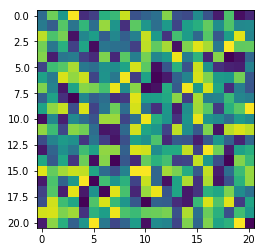

In [21]:
if(__name__ == "__main__"):
    #dataDir = "/projects/0/ismi2018/FINALPROJECTS/BREAST_THOMOSYNTHESIS"
    dataDir = "./testData"
    #make_dummy_data(10,(500,500),dataDir)
    gen = PatchGenerator(dataDir,32,1,(21,21))

    for batch_x, batch_y in gen:
        print(batch_y[31])
        print(batch_x[31,10,10,0])
        
        plt.imshow(batch_x[0,:,:,0])
        plt.show()
        break